In [68]:
from capetools.utils import *
from fastprogress import progress_bar

from typing import Union #python 3.6
from pathlib import Path  #python 3

#importantes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PSDA data explore
> Exploring the psda early data with python

We will first setup the data needed to plot some nice curves. To do so we will process the `.txt` files onto pandas `DataFrame`'s. We define some file paths and helper functions to make this task easier.

In [5]:
PATH = Path('data_psda')  #aqui! (path relativo)
vert_path = PATH/'Vertical'

In [6]:
vert_path.ls()

[WindowsPath('data_psda/Vertical/20191028_RefCellsVert.txt'),
 WindowsPath('data_psda/Vertical/20191028_TempModVert.txt'),
 WindowsPath('data_psda/Vertical/20191028_WindVertical.txt'),
 WindowsPath('data_psda/Vertical/20191213_RefCellsVert.txt'),
 WindowsPath('data_psda/Vertical/20191213_TempModVert.txt'),
 WindowsPath('data_psda/Vertical/20191213_WindVertical.txt'),
 WindowsPath('data_psda/Vertical/20191214_RefCellsVert.txt'),
 WindowsPath('data_psda/Vertical/20191214_TempModVert.txt'),
 WindowsPath('data_psda/Vertical/20191214_WindVertical.txt'),
 WindowsPath('data_psda/Vertical/20191215_RefCellsVert.txt'),
 WindowsPath('data_psda/Vertical/20191215_TempModVert.txt'),
 WindowsPath('data_psda/Vertical/20191215_WindVertical.txt'),
 WindowsPath('data_psda/Vertical/20191216_RefCellsVert.txt'),
 WindowsPath('data_psda/Vertical/20191216_TempModVert.txt'),
 WindowsPath('data_psda/Vertical/20191216_WindVertical.txt'),
 WindowsPath('data_psda/Vertical/20191217_RefCellsVert.txt'),
 WindowsPath(

In [9]:
def get_file_names(path: Union[Path, str]=Path('.'), extension: str=None)->list:
    "get filenames at current path"
    ext = ifnone(extension, '')
    path = Path(path)
    return [p.name for p in path.ls() if (p.name).endswith(ext)]

In [10]:
filenames = get_file_names(vert_path, '.txt'); filenames

['20191028_RefCellsVert.txt',
 '20191028_TempModVert.txt',
 '20191028_WindVertical.txt',
 '20191213_RefCellsVert.txt',
 '20191213_TempModVert.txt',
 '20191213_WindVertical.txt',
 '20191214_RefCellsVert.txt',
 '20191214_TempModVert.txt',
 '20191214_WindVertical.txt',
 '20191215_RefCellsVert.txt',
 '20191215_TempModVert.txt',
 '20191215_WindVertical.txt',
 '20191216_RefCellsVert.txt',
 '20191216_TempModVert.txt',
 '20191216_WindVertical.txt',
 '20191217_RefCellsVert.txt',
 '20191217_TempModVert.txt',
 '20191217_WindVertical.txt']

In [11]:
def unique_names(filenames):
    "get unique names in filenames"
    names_list = [f[9:-4] for f in filenames]
    return list(pd.Series(names_list).unique())

In [12]:
unames = unique_names(filenames); unames

['RefCellsVert', 'TempModVert', 'WindVertical']

In [13]:
def get_file_lists(path):
    "Get file list for different data streams"
    filenames = get_file_names(path, '.txt')
    unames = unique_names(filenames)
    dict_out = {k:[] for k in unames}
    for fname in filenames:
        dict_out[fname[9:-4]].append(fname)
    return dict_out

In [14]:
file_dict = get_file_lists(vert_path); file_dict

{'RefCellsVert': ['20191028_RefCellsVert.txt',
  '20191213_RefCellsVert.txt',
  '20191214_RefCellsVert.txt',
  '20191215_RefCellsVert.txt',
  '20191216_RefCellsVert.txt',
  '20191217_RefCellsVert.txt'],
 'TempModVert': ['20191028_TempModVert.txt',
  '20191213_TempModVert.txt',
  '20191214_TempModVert.txt',
  '20191215_TempModVert.txt',
  '20191216_TempModVert.txt',
  '20191217_TempModVert.txt'],
 'WindVertical': ['20191028_WindVertical.txt',
  '20191213_WindVertical.txt',
  '20191214_WindVertical.txt',
  '20191215_WindVertical.txt',
  '20191216_WindVertical.txt',
  '20191217_WindVertical.txt']}

# Parsing datetime string format

In [15]:
import dateutil
dp = dateutil.parser.parser()

In [16]:
s = '2019_12_14 00:05:00'

In [17]:
parser = lambda date: pd.datetime.strptime(date, '%Y_%m_%d %H:%M:%S')

In [18]:
parser(s)

datetime.datetime(2019, 12, 14, 0, 5)

In [19]:
def f(name, last): return f'Name: {name}, Last: {last}'

In [20]:
f('Seba', 'Donoso')

'Name: Seba, Last: Donoso'

In [21]:
f(last='Donoso', name='Hola')

'Name: Hola, Last: Donoso'

In [22]:
def read_data(path=vert_path, filename='20191214_RefCellsVert.txt', **kwargs):
    df = pd.read_csv(path/filename, 
                     sep=';', 
                     decimal=',', 
                     error_bad_lines=False,
                     warn_bad_lines=True,
                     **kwargs)
    df['datetime']=pd.to_datetime(df['TimeStamp'], format='%Y_%m_%d %H:%M:%S')
    df = df.set_index('datetime').drop('TimeStamp', axis=1)
    return df

In [23]:
df = read_data()

In [24]:
def get_dataframes(path=vert_path, force=False):
    "reads .txt in path and concats to pandas hdf"
    file_dict = get_file_lists(path)
    for name,filenames in progress_bar(file_dict.items()):
        if not (path/(name+'.hdf')).is_file() or force:
            df = pd.concat([read_data(path, f) for f in filenames])
            df.reset_index().to_feather(path/(name+'.hdf'))
    return [k+'.hdf' for k in file_dict.keys()]

In [25]:
get_dataframes(path=vert_path, force=True)

['RefCellsVert.hdf', 'TempModVert.hdf', 'WindVertical.hdf']

# Vertical Installation
>Let's look at the data

In [26]:
df = pd.read_feather(vert_path/'RefCellsVert.hdf').set_index('datetime')

In [27]:
df.index

DatetimeIndex(['2019-10-28 15:45:52', '2019-10-28 16:06:26',
               '2019-10-28 16:20:08', '2019-10-28 16:20:48',
               '2019-10-28 16:20:58', '2019-10-28 16:21:03',
               '2019-10-28 16:21:08', '2019-10-28 16:21:13',
               '2019-10-28 16:21:18', '2019-10-28 16:21:23',
               ...
               '2019-12-17 10:52:46', '2019-12-17 10:52:51',
               '2019-12-17 10:52:56', '2019-12-17 10:53:01',
               '2019-12-17 10:53:06', '2019-12-17 10:53:11',
               '2019-12-17 10:53:16', '2019-12-17 10:53:21',
               '2019-12-17 10:53:26', '2019-12-17 10:53:31'],
              dtype='datetime64[ns]', name='datetime', length=69680, freq=None)

We are going to look at vertical west facing reference cells.

In [28]:
west_refs = [104,105,106,110,111,112,116,117,118,122,123,124]
west_dict = {k:f'1RC{k}(w.m-2)' for k in west_refs}

A quick dictionary to make our life easier

In [29]:
west_dict

{104: '1RC104(w.m-2)',
 105: '1RC105(w.m-2)',
 106: '1RC106(w.m-2)',
 110: '1RC110(w.m-2)',
 111: '1RC111(w.m-2)',
 112: '1RC112(w.m-2)',
 116: '1RC116(w.m-2)',
 117: '1RC117(w.m-2)',
 118: '1RC118(w.m-2)',
 122: '1RC122(w.m-2)',
 123: '1RC123(w.m-2)',
 124: '1RC124(w.m-2)'}

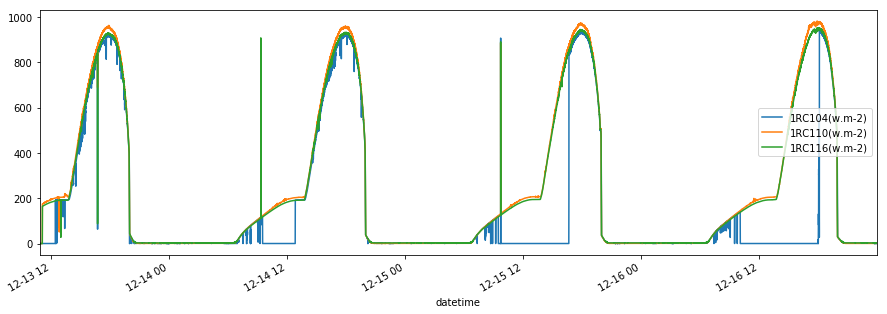

In [30]:
def plot_date(date=slice(None), cols=[], **plot_kwargs):
    fig, ax = plt.subplots()
    cols = [west_dict[k] for k in cols]
    df.loc[date, cols].plot(ax=ax, **plot_kwargs)
    plt.legend(loc=5)
    return fig

fig = plot_date(date=slice('13 Dec 2019','16 Dec 2019'), 
          cols=[104,110,116],
          figsize=(15,5))

In [31]:
fig.savefig('ref_cells_vert.png')

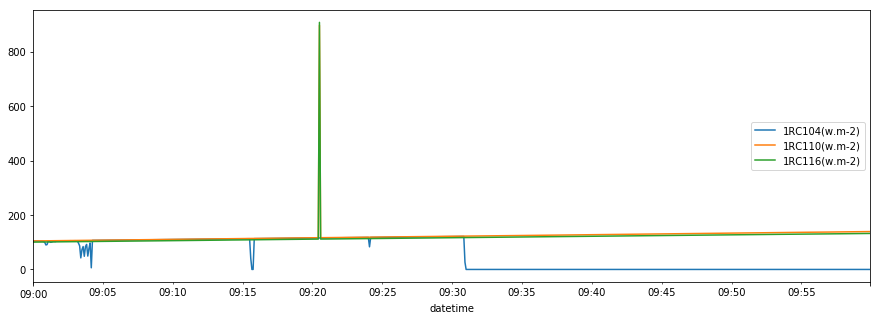

In [32]:
fig = plot_date(date='9h 14 Dec 2019', 
          cols=[104,110,116],
          figsize=(15,5))

Top cells facing west

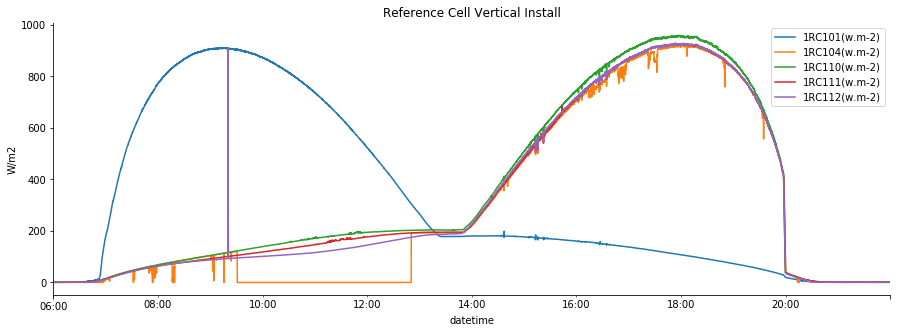

In [127]:
fig, ax = plt.subplots()
df.loc['6h 14 Dec 2019':'21h 14 Dec 2019', '1RC101(w.m-2)'].plot(ax=ax, figsize=(15,5))
# # df.loc[slice(None), '1RC102(w.m-2)'].plot()
# # df.loc[slice(None), '1RC103(w.m-2)'].plot()
df.loc['6h 14 Dec 2019':'21h 14 Dec 2019', '1RC104(w.m-2)'].plot(ax=ax)
# df.loc['6h 14 Dec 2019':'21h 14 Dec 2019', '1RC105(w.m-2)'].plot()
# df.loc['6h 14 Dec 2019':'21h 14 Dec 2019', '1RC106(w.m-2)'].plot()
df.loc['6h 14 Dec 2019':'21h 14 Dec 2019', '1RC110(w.m-2)'].plot(ax=ax)
df.loc['6h 14 Dec 2019':'21h 14 Dec 2019', '1RC111(w.m-2)'].plot(ax=ax)
df.loc['6h 14 Dec 2019':'21h 14 Dec 2019', '1RC112(w.m-2)'].plot(ax=ax)
ax.set_ylabel('W/m2')
ax.set_title('Reference Cell Vertical Install')
plt.legend()
sns.despine()

In [129]:
fig.savefig('refcells_vertical.png')

# Fixed

In [34]:
fixed_path = PATH/'Fixed'
get_dataframes(fixed_path, force=True)

['RefCellsFixed.hdf', 'TempModFixed.hdf', 'WindFixed.hdf']

In [35]:
df2 = pd.read_feather(fixed_path/'RefCellsFixed.hdf').set_index('datetime')

In [36]:
df2.columns

Index(['1RC401(w.m-2)', '1RC401(C)', '1RC402(w.m-2)', '1RC402(C)',
       '1RC403(w.m-2)', '1RC403(C)', '1RC404(w.m-2)', '1RC404(C)',
       '1RC405(w.m-2)', '1RC405(C)', '1RC406(w.m-2)', '1RC406(C)',
       '1RC407(w.m-2)', '1RC407(C)', '1RC408(w.m-2)', '1RC408(C)',
       '1RC409(w.m-2)', '1RC409(C)', '1RC410(w.m-2)', '1RC410(C)',
       '1RC411(w.m-2)', '1RC411(C)', '1RC412(w.m-2)', '1RC412(C)'],
      dtype='object')

In [37]:
irradiances = [col for col in df2.columns if ('w.m' in str(col))]

In [38]:
import pvlib.solarposition as sunpos

In [39]:
sol_pos = sunpos.get_solarposition(df2.index, latitude=-22.3, longitude=-69.9, altitude=720, tz=-4)

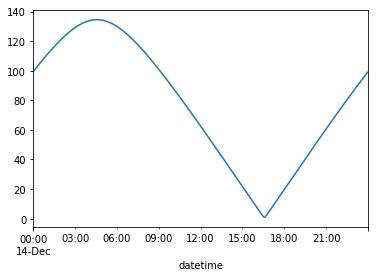

In [40]:
sol_pos['14 Dec 2019'].zenith.plot()

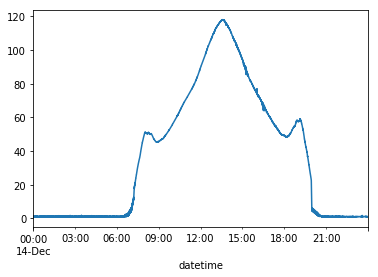

In [41]:
df2.loc['14 Dec 2019', '1RC401(w.m-2)'].plot()

In [42]:
df2 = pd.concat([df2, sol_pos], axis=1)

In [43]:
df2.columns

Index(['1RC401(w.m-2)', '1RC401(C)', '1RC402(w.m-2)', '1RC402(C)',
       '1RC403(w.m-2)', '1RC403(C)', '1RC404(w.m-2)', '1RC404(C)',
       '1RC405(w.m-2)', '1RC405(C)', '1RC406(w.m-2)', '1RC406(C)',
       '1RC407(w.m-2)', '1RC407(C)', '1RC408(w.m-2)', '1RC408(C)',
       '1RC409(w.m-2)', '1RC409(C)', '1RC410(w.m-2)', '1RC410(C)',
       '1RC411(w.m-2)', '1RC411(C)', '1RC412(w.m-2)', '1RC412(C)',
       'apparent_zenith', 'zenith', 'apparent_elevation', 'elevation',
       'azimuth', 'equation_of_time'],
      dtype='object')

In [44]:
idx_day = df2.elevation>0

In [48]:
df2.loc[slice(None), irradiances].max()

1RC401(w.m-2)     767.49
1RC402(w.m-2)     141.25
1RC403(w.m-2)     270.53
1RC404(w.m-2)     194.42
1RC405(w.m-2)     203.11
1RC406(w.m-2)     211.79
1RC407(w.m-2)     549.87
1RC408(w.m-2)     567.37
1RC409(w.m-2)     527.27
1RC410(w.m-2)    1078.53
1RC411(w.m-2)    1076.04
1RC412(w.m-2)    1074.38
dtype: float64

In [49]:
front = df2[irradiances].columns[df2.loc[slice(None), irradiances].max()>1000]
back = df2[irradiances].columns[df2.loc[slice(None), irradiances].max()<900]

In [50]:
front

Index(['1RC410(w.m-2)', '1RC411(w.m-2)', '1RC412(w.m-2)'], dtype='object')

In [51]:
back

Index(['1RC401(w.m-2)', '1RC402(w.m-2)', '1RC403(w.m-2)', '1RC404(w.m-2)',
       '1RC405(w.m-2)', '1RC406(w.m-2)', '1RC407(w.m-2)', '1RC408(w.m-2)',
       '1RC409(w.m-2)'],
      dtype='object')

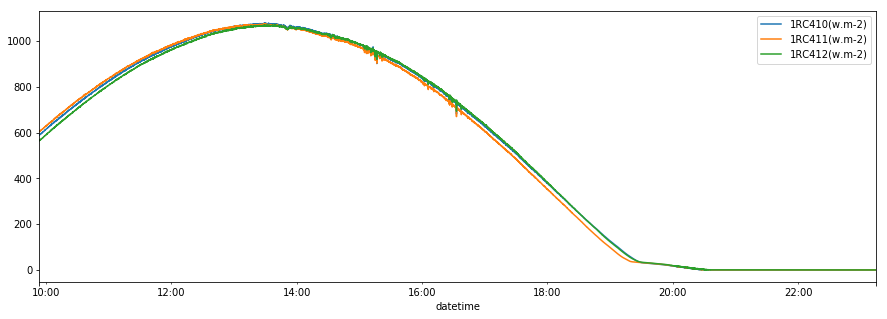

In [53]:
df2[idx_day].loc['14 Dec 2019', front].plot(figsize=(15,5))

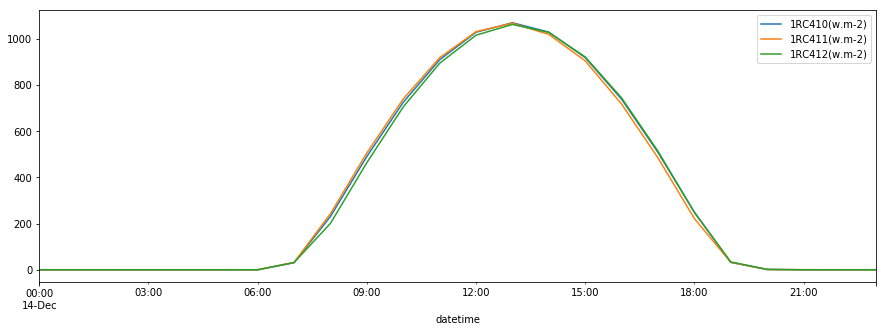

In [54]:
#requiere TimeIndex
df2.resample('1H').median().loc['14 Dec 2019', front].plot(figsize=(15,5))

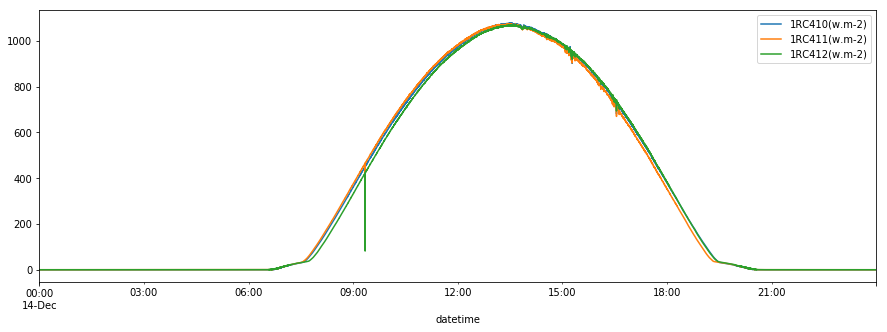

In [55]:
df2.loc['14 Dec 2019', front].plot(figsize=(15,5))

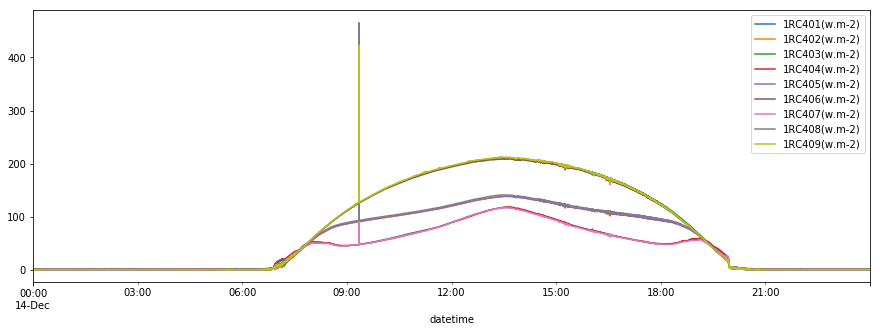

In [56]:
df2.loc['14 Dec 2019',back].plot(figsize=(15,5))

# Inverters

In [57]:
power_path = PATH/'Power'
get_dataframes(power_path, force=True)

['ACpowerNorth.hdf',
 'ACpowerSouth.hdf',
 'DCpowerNorth.hdf',
 'DCpowerSouth.hdf']

In [58]:
df_power = pd.read_feather(power_path/'DCpowerSouth.hdf').set_index('datetime')

In [59]:
df_power.head()

,1VE501(V),1IE501(A),1PE501(W),1VE502(V),1IE502(A),1PE502(W),1VE503(V),1IE503(A),1PE503(W),1VE504(V),...,1PE505(W),1VE506(V),1IE506(A),1PE506(W),1VE507(V),1IE507(A),1PE507(W),1VE508(V),1IE508(A),1PE508(W)
datetime,,,,,,,,,,,,,,,,,,,,,
2019-10-28 15:45:52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-28 16:06:26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-28 16:20:08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-28 16:20:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-28 16:20:58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
df_power.columns

Index(['1VE501(V)', '1IE501(A)', '1PE501(W)', '1VE502(V)', '1IE502(A)',
       '1PE502(W)', '1VE503(V)', '1IE503(A)', '1PE503(W)', '1VE504(V)',
       '1IE504(A)', '1PE504(W)', '1VE505(V)', '1IE505(A)', '1PE505(W)',
       '1VE506(V)', '1IE506(A)', '1PE506(W)', '1VE507(V)', '1IE507(A)',
       '1PE507(W)', '1VE508(V)', '1IE508(A)', '1PE508(W)'],
      dtype='object')

In [61]:
south_current = {n:f'1IE50{n}(A)' for n in range(1,9)}

In [65]:
fixed_current = {n:f'1IE50{n}(A)' for n in range(1,5)}
tracker_current = {n:f'1IE50{n}(A)' for n in range(5,9)}

In [97]:
def plot_5T(date='14 Dec 2019', cols=fixed_current.values(), ylabel='A', data=df_power):
    fig, ax = plt.subplots()
    (data.resample('5T')
             .median()
             .loc[date,cols]
             .plot(ax=ax, figsize=(15,5)))
    sns.despine()
    ax.set_ylabel(ylabel)
    return fig

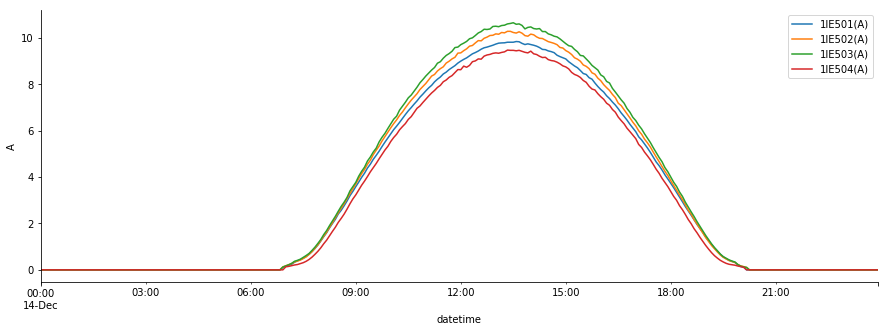

In [98]:
plot_5T();

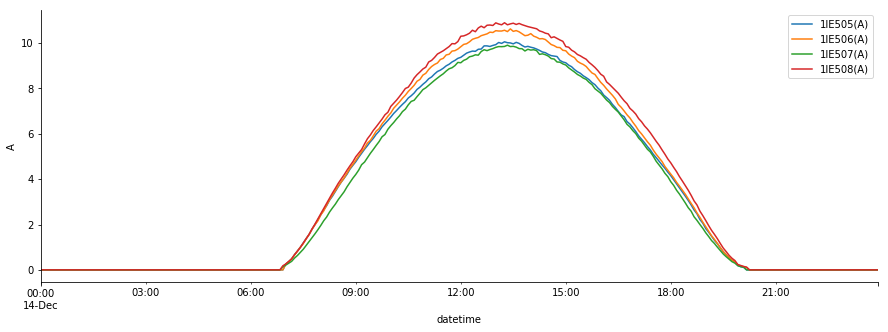

In [99]:
plot_5T('14 Dec 2019', tracker_current.values());

## Power

In [100]:
fixed_power = {n:f'1PE50{n}(W)' for n in range(1,5)}
tracker_power = {n:f'1PE50{n}(W)' for n in range(5,9)}

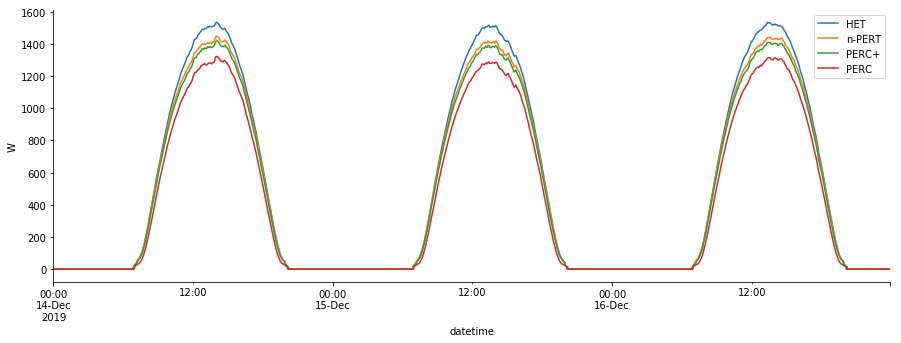

In [138]:
fig = plot_5T(slice('14 Dec 2019', '16 Dec 2019'), [fixed_power[1],
                                                    fixed_power[3], 
                                                    fixed_power[2], 
                                                    fixed_power[4]], ylabel='W')
plt.legend(['HET','n-PERT','PERC+','PERC'])

In [139]:
fig.savefig('power_fixed.png')

In [107]:
df_power_n = pd.read_feather(power_path/'DCpowerNorth.hdf').set_index('datetime')

In [108]:
df_power_n.columns

Index(['1VE301(V)', '1IE301(A)', '1PE301(W)', '1VE302(V)', '1IE302(A)',
       '1PE302(W)', '1VE303(V)', '1IE303(A)', '1PE303(W)'],
      dtype='object')

In [109]:
vertical_power = {n:f'1PE30{n}(W)' for n in range(1,3)}

Oups, there is no data for North container...

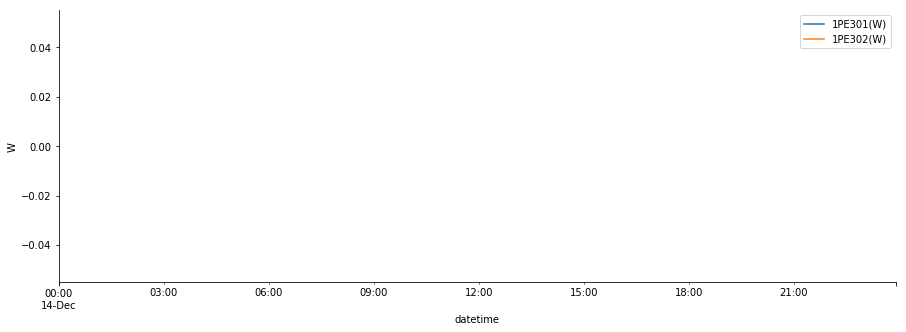

In [114]:
plot_5T(cols=vertical_power.values(), ylabel='W', data=df_power_n);

## AC

In [163]:
ac_power_n = pd.read_feather(power_path/'ACpowerNorth.hdf').set_index('datetime')

In [164]:
ac_power_n.columns

Index(['FrequencyInvert1(Hz)', 'VoltageInvert1(V)', 'CurrentInvert1(A)',
       'ActivePowerInvert1(W)', 'ReactivePowerInvert1(VAr)',
       'FrequencyInvert2(Hz)', 'VoltageInvert2(V)', 'CurrentInvert2(A)',
       'ActivePowerInvert2(W)', 'ReactivePowerInvert2(VAr)'],
      dtype='object')

In [167]:
vertical_power_n = {n:f'ActivePowerInvert{n}(W)' for n in range(1,3)}

Vertical install has 3 `strings`, with only 2 `inverters`, so you have very different `AC` outputs.

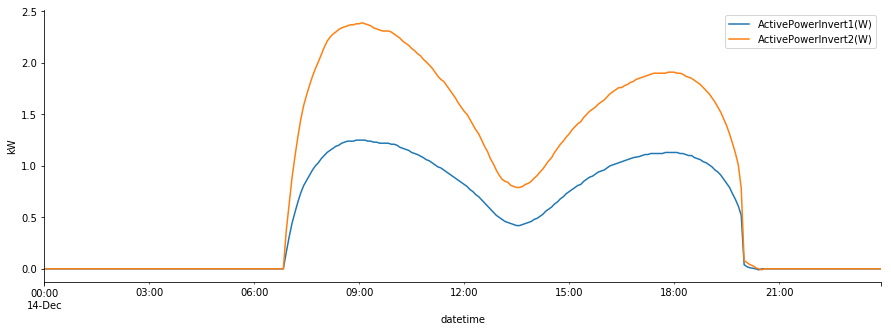

In [168]:
plot_5T(cols=vertical_power_n.values(), ylabel='kW', data=ac_power_n);

South

In [169]:
ac_power_s = pd.read_feather(power_path/'ACpowerSouth.hdf').set_index('datetime')

In [170]:
ac_power_s.columns

Index(['FrequencyInvert3(Hz)', 'VoltageInvert3(V)', 'CurrentInvert3(A)',
       'ActivePowerInvert3(W)', 'ReactivePowerInvert3(VAr)',
       'FrequencyInvert4(Hz)', 'VoltageInvert4(V)', 'CurrentInvert4(A)',
       'ActivePowerInvert4(W)', 'ReactivePowerInvert4(VAr)',
       'FrequencyInvert5(Hz)', 'VoltageInvert5(V)', 'CurrentInvert5(A)',
       'ActivePowerInvert5(W)', 'ReactivePowerInvert5(VAr)',
       'FrequencyInvert6(Hz)', 'VoltageInvert6(V)', 'CurrentInvert6(A)',
       'ActivePowerInvert6(W)', 'ReactivePowerInvert6(VAr)'],
      dtype='object')

In [171]:
vertical_power_s = {n:f'ActivePowerInvert{n}(W)' for n in range(3,7)}

In [172]:
vertical_power_s

{3: 'ActivePowerInvert3(W)',
 4: 'ActivePowerInvert4(W)',
 5: 'ActivePowerInvert5(W)',
 6: 'ActivePowerInvert6(W)'}

We have 4 strings on the `tracker` and 4 strings on the `fixed` installation. Each `inverter` has 2 strings attached, as the `tracker` is not working (it is horizontal), curves are similar.

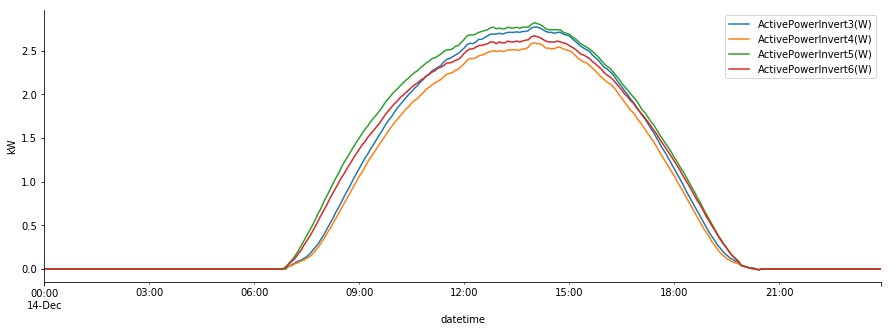

In [174]:
plot_5T(cols=vertical_power_s.values(), ylabel='kW', data=ac_power_s);